# Plotting Regional Gravity Map of Iceland

Author: **Marcin Sikorski**<br>
Date: December, 2021

### Introduction

Modern geodesists and various Earth scientists rely on geographic information systems (GIS) for creating all kinds of thematic maps. These systems also contain useful data for further spatial and geodetic analysis. Unfortunately, most GIS software requires expensive commercial licenses and contain limited features for the user to work on maps. Plotting maps can also be done using Python or any programming language which can offer more flexibility in map modifications. This notebook presents a simple methodology for generating gravity maps in Python. To understand the usefulness of this kind of map, it is advisable to know the explanation of gravity anomaly:

**Gravity anomaly** is the difference between the observed value of gravity at a given point of the Earth's surface and the corresponding theoretical value predicted from a model of the planet's gravitational field. It is mostly caused by Earth's mass distribution, geological structure, relief, altitude above sea level and celestial bodies. The knowledge of gravity distribution on the Earth's surface is significant in the study of the figure of Earth and in the search for mineral deposits.

In [1]:
from IPython.display import Image
Image(url='https://www.researchgate.net/profile/Enrico-Canuto/publication/\
4006394/figure/fig1/AS:669963631198222@1536743185363/\
Earth-geoid-and-gravity-anomaly-Gravity-anomalies-are-the-difference-between-the.png')

In [2]:
Image(url='https://www.researchgate.net/profile/Vinay-Kumar-43/publication\
/316454897/figure/fig1/AS:486959211651072@1493111531109/\
Topography-of-Iceland-with-glacier-distribution-The-main-icecaps-are-bordered-by.png')

### Geography of Iceland

Iceland is both an island and country located in Northern Europe, straddling the Eurasian and North American plates between the Greenland Sea and the North Atlantic Ocean, northwest of the British Isles. It's terrain consists mainly of a central volcanic plateau, with elevations from about 700 to 800 m, ringed by mountains. The island is famous for it's volcanic activity, glaciers, highland landscape and coastal fjords.

### Dataset Describtion

The data points for this repository were extracted from [Topex][1] website and are satellite altimetry origin 
with global 1' grids in ASCII XYZ-format. Gravity is V29.1.

For Iceland the range was defined as 63.2&deg;N, -24.6&deg;W for bottom left corner and 66.6&deg;N, -23.0&deg;W for upper right corner.

[1]: https://topex.ucsd.edu/cgi-bin/get_data.cgi 'Topex'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# importing data points
df = pd.read_csv('gravity.txt', sep='\t', names=['long', 'lat', 'grav'])

# correcting longitude
df.iloc[:,0] = df.iloc[:,0] - 360

In [5]:
df.head()

,long,lat,grav
0,-24.5917,66.6028,64.4
1,-24.5750,66.6028,64.2
2,-24.5583,66.6028,64.0
3,-24.5417,66.6028,63.6
4,-24.5250,66.6028,63.1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0C5593A0>]],
      dtype=object)

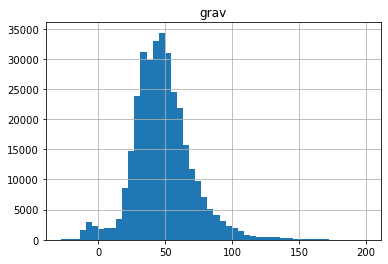

In [6]:
# approximate distribution of gravity data
df.hist(column='grav', bins=50)

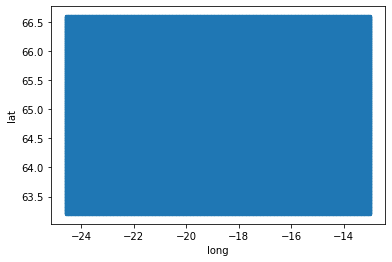

In [7]:
# horizontal distribution of points
df.plot.scatter(x='long', y='lat', marker='.')

Point distribution seems to be dense enough for plotting our gravity map. We will skip point interpolation.

### 1. Static Map in Matplotlib

In [8]:
# scaling and centering diverging colorbar for better presentation - with 0.0 value in middle
# http://chris35wills.github.io/matplotlib_diverging_colorbar/

import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

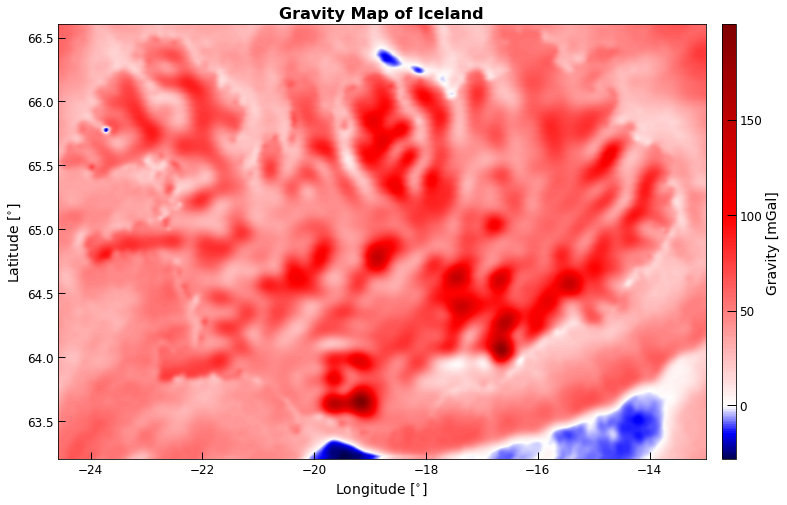

In [9]:
# plot size
plt.figure(figsize=(14,8))

# delete margins/white spaces
plt.margins(0)

# defining values for colorbar
min_val = min(df.iloc[:,2])
max_val = max(df.iloc[:,2])
mid_val = 0.0

# colormap normalization
norm = MidpointNormalize(midpoint=mid_val, vmin=min_val, vmax=max_val)

# plot
plt.scatter(x=df.iloc[:,0], y=df.iloc[:,1], c=df.iloc[:,2], cmap='seismic',\
            clim=(min_val, max_val), norm=norm)

# colorbar
cbar = plt.colorbar(pad=.02, aspect=30)
cbar.set_label(label='Gravity [mGal]', size=14)
cbar.ax.tick_params(labelsize=12, direction='in', size=9, width=1)

# labels
plt.title('Gravity Map of Iceland', size=16, weight='bold')
plt.xlabel('Longitude [$^{\circ}$]', size=14)
plt.ylabel('Latitude [$^{\circ}$]', size=14)
plt.tick_params(axis='both', direction='in', size=7, width=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# saving to png file
plt.savefig('iceland_gravity.png')

Some conclusions:
* Iceland in general is a dense plateau. It's mass isn't distributed evenly. Varying surface topography and magmatic activity cause different parts of the island to have more or less mass than other regions.
* This map is easy to interpret. Darker red represent areas with strong gravity. Blue colors represent areas with weak (negative) gravity. Mountain ranges have a high concentration of mass, and therefore have stronger gravity field. Vice versa ocean trenches have a low concentration of mass, and therefore have much weaker gravity field.
* The light red colored surafaces outside Iceland's border is most likely it's continental shelf.
* The coastline which is the sea level and approximately Earth's equipotential surface, is marked on the map in white color (0 [mGal]). It's an area or space where every point in it has constant gravity potential.

### 2. Interactive Map in Plotly

In [10]:
import plotly.express as px

# min and max range for color bar 
min_v = min(df['grav'])
max_v = max(df['grav'])

# plot
fig = px.scatter(data_frame=df, x='long', y='lat', color='grav',
                 custom_data=['lat', 'long', 'grav'],
                 labels={'lat': 'φ', 'long': 'λ', 'grav':'g'},
                 color_continuous_scale=px.colors.diverging.Portland,
                 range_color=(min_v, max_v))

# adding labels
fig.update_layout(
    title=dict(text='<b>Gravity Map of Iceland</b>', x=0.5, font=dict(size=16)),
    xaxis_title='Longitude [°]',
    yaxis_title='Latitude [°]',
    coloraxis_colorbar=dict(title='Gravity [mGal]', ticks='inside', ticklen=9, tickwidth=1),
    height=600, width=850)

# customizing x-axis
fig.update_xaxes(showgrid=False, zeroline=False,
                 title_font=dict(size=14),
                 ticks='inside', tickson='boundaries', ticklen=7, tickwidth=1)

# customizing y-axis
fig.update_yaxes(showgrid=False, zeroline=False,
                 title_font=dict(size=14),
                 ticks='inside', tickson='boundaries', ticklen=7, tickwidth=1)

# customizing hover template
fig.update_traces(hovertemplate='φ = %{customdata[0]:.3f}°'
                  +'<br>λ = %{customdata[1]:.3f}°'
                  +'<br>g = %{customdata[2]} [mGal]')

# set visible floating menu
config = {'displayModeBar': True, 'displaylogo': False}

import plotly
# saving to html file
plotly.offline.plot(fig, filename='iceland_gravity.html', config=config)

'iceland_gravity.html'

Both maps were exported and attached to this repository.

### Conclusions

Maps are vital into most applications within the Earth sciences for a variety of different uses such as mapping elevation distributions for surveying, visualizing features, or as basemaps for plotting any kind of geospatial data. Maps are base tools used extensively by reaserchers in academia or professionals in industry. We as common people also need them for practical purposes such as navigation aid.

In this notebook we generated a regional gravity map using object-oriented programming language. We obtained data points from a web API by defining our area of interest and used them to plot our thematic map. Two maps of Iceland were created using the same gravity data:
* static in PNG format;
* interactive in HTML - this one shows more accurate data by hovering cursor over map contents. 

Access to GIS software and license are quite expensive and are not required to generate basic maps as they can be drafted by following the methodology presented here. We proved that knowlegde of any standard programming language can offer lots of flexibility and functions in modificating maps, such as customizing colorbars or axes. Python has enough useful functions for obtaining and preparing geospatial datasets for further visualizing.